In [373]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [374]:
import assignment3_functions as library
import pandas as pd
import numpy as np
from sklearn import (svm, ensemble, tree,
                     linear_model, neighbors, naive_bayes, dummy)
pd.options.display.max_columns = 999
import warnings 
warnings.simplefilter('ignore')
from datetime import date, datetime, timedelta

In [375]:
donors_df = library.file_to_dataframe("projects_2012_2013.csv")

In [376]:
donors_df['date_posted'] = pd.to_datetime(donors_df['date_posted'], format='%m/%d/%y')
donors_df['datefullyfunded'] = pd.to_datetime(donors_df['datefullyfunded'], format='%m/%d/%y')
donors_df['60_days_fullyfunded'] = np.where(donors_df['datefullyfunded'] - donors_df['date_posted'] <= pd.to_timedelta(60, unit='days'), 0, 1)
donors_df.head()

projectid                    teacher_acctid  \
0  00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1  0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2  000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3  0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4  0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   

                           schoolid  school_ncesid  school_latitude  \
0  9f3f9f2c2da7edda5648ccd10554ed8c   1.709930e+11        41.807654   
1  3432ed3d4466fac2f2ead83ab354e333   6.409801e+10        34.296596   
2  dc8dcb501c3b2bb0b10e9c6ee2cd8afd   6.227100e+10        34.078625   
3  8bea7e8c6e4279fca6276128db89292e   3.600090e+11        40.687286   
4  fbdefab6fe41e12c55886c610c110753   3.606870e+11        40.793018   

   school_longitude    school_city school_state school_metro  \
0        -87.673257        Chicago           IL        urban   
1       -119.296596        Ventura           CA        urban   
2       -118.257834    Los Angeles           CA        urban   
3        -73.988217       Brooklyn           NY        urban   
4        -73.205635  Central Islip           NY     suburban   

                school_district     school_county school_charter  \
0         Pershing Elem Network              Cook              f   
1  Ventura Unif School District           Ventura              f   
2     Los Angeles Unif Sch Dist       Los Angeles              f   
3      New York City Dept Of Ed  Kings (Brooklyn)              f   
4   Central Islip Union Free SD           Suffolk              f   

  school_magnet teacher_prefix primary_focus_subject   primary_focus_area  \
0             f           Mrs.           Mathematics       Math & Science   
1             f           Mrs.   Civics & Government     History & Civics   
2             f            Ms.              Literacy  Literacy & Language   
3             t            Ms.              Literacy  Literacy & Language   
4             f           Mrs.              Literacy  Literacy & Language   

  secondary_focus_subject secondary_focus_area resource_type    poverty_level  \
0             Visual Arts     Music & The Arts      Supplies  highest poverty   
1    Literature & Writing  Literacy & Language         Books  highest poverty   
2         Social Sciences     History & Civics    Technology     high poverty   
3                     NaN                  NaN         Books     high poverty   
4    Literature & Writing  Literacy & Language    Technology     high poverty   

     grade_level  total_price_including_optional_support  students_reached  \
0  Grades PreK-2                                 1498.61              31.0   
1     Grades 3-5                                  282.47              28.0   
2     Grades 3-5                                 1012.38              56.0   
3  Grades PreK-2                                  175.33              23.0   
4  Grades PreK-2                                 3591.11             150.0   

  eligible_double_your_impact_match date_posted datefullyfunded  \
0                                 f  2013-04-14      2013-05-02   
1                                 t  2012-04-07      2012-04-18   
2                                 f  2012-01-30      2012-04-15   
3                                 f  2012-10-11      2012-12-05   
4                                 f  2013-01-08      2013-03-25   

   60_days_fullyfunded  
0                    0  
1                    0  
2                    1  
3                    0  
4                    1

#### Inspecting NAs

In [378]:
library.na_summary(donors_df)

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

#### Strategy for imputing: Looking at the NA summary above, it looks like I will need to impute school_metro, school_district, primary_focus_subject, primary_focus_area, secondary_focus_subject, secondary_focus_area, resource_type, grade_level, and students_reached. This will happen in the pre-processing step, after doing train, test splits

In [379]:
to_dummy_list = ['school_magnet', 'school_charter', 'eligible_double_your_impact_match']
categorical_list = ['teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'school_district', 'secondary_focus_subject', 'secondary_focus_area', 'school_state', 'school_city', 'school_metro', 'school_county']
continuous_impute_list = ['students_reached']
vars_to_drop_all = ['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_longitude', 'school_latitude']
vars_to_drop_dates = ['date_posted', 'datefullyfunded', '60_days_fullyfunded']

#### Fix temporal split function

In [380]:
start_time_6mo = '2012-01-01'
end_time_6mo = '2013-12-31'
prediction_windows = [6]
temp_split_6mo = library.temporal_dates(start_time_6mo, end_time_6mo, prediction_windows, 60)
temp_split_6mo

[[datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 4, 30, 0, 0),
  datetime.datetime(2012, 7, 1, 0, 0),
  datetime.datetime(2012, 10, 31, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2012, 10, 31, 0, 0),
  datetime.datetime(2013, 1, 1, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  6],
 [datetime.datetime(2012, 1, 1, 0, 0),
  datetime.datetime(2013, 4, 30, 0, 0),
  datetime.datetime(2013, 7, 1, 0, 0),
  datetime.datetime(2013, 10, 31, 0, 0),
  6]]

In [381]:
models_to_run = ['RF', 'AB', 'LR', 'KNN', 'SVM', 'DT', 'GB', 'BG']
 
classifiers = {'RF': ensemble.RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': linear_model.LogisticRegression(penalty='l1', C=1e5, n_jobs=-1),
    'SVM': svm.LinearSVC(tol= 1e-5, random_state=0),
    'AB': ensemble.AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'DT': tree.DecisionTreeClassifier(),
    'KNN': neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    'GB': ensemble.GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'BG': ensemble.BaggingClassifier(linear_model.LogisticRegression(penalty='l1', C=1e5, n_jobs=-1))
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5, 20, 100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.1,1,10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,10,20,100],'min_samples_split': [2,5,10]},
    'SVM': {'C': [0.01]},
    'KNN': {'n_neighbors': [25],'weights': ['uniform','distance'],'algorithm': ['ball_tree']},
    'GB': {'n_estimators': [10], 'learning_rate': [0.1,0.5], 'subsample': [0.1,0.5], 'max_depth': [5]},
    'BG': {'n_estimators': [10], 'max_samples': [.5]}
           }

In [383]:
results_df, params = library.run_models(models_to_run, classifiers, parameters, donors_df, '60_days_fullyfunded', categorical_list, to_dummy_list, continuous_impute_list, vars_to_drop_all, vars_to_drop_dates, "table_with_KNN.csv", temp_split_6mo, "date_posted")

Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...
Running through model RF...
Running through model AB...
Running through model LR...
Running through model KNN...
Running through model SVM...
Running through model DT...
Running through model GB...
Running through model BG...


In [384]:
results_df

train_start  train_end test_start   test_end model_type  \
0   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
1   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
2   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
3   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
4   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
5   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
6   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
7   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
8   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
9   2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
10  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
11  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
12  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
13  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
14  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
15  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
16  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
17  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
18  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
19  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
20  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
21  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
22  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
23  2012-01-01 2013-04-30 2013-07-01 2013-10-31         RF   
24  2012-01-01 2013-04-30 2013-07-01 2013-10-31         AB   
25  2012-01-01 2013-04-30 2013-07-01 2013-10-31         LR   
26  2012-01-01 2013-04-30 2013-07-01 2013-10-31         LR   
27  2012-01-01 2013-04-30 2013-07-01 2013-10-31         LR   
28  2012-01-01 2013-04-30 2013-07-01 2013-10-31         LR   
29  2012-01-01 2013-04-30 2013-07-01 2013-10-31         LR   
..         ...        ...        ...        ...        ...   
36  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
37  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
38  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
39  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
40  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
41  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
42  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
43  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
44  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
45  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
46  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
47  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
48  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
49  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
50  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
51  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
52  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
53  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
54  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
55  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
56  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
57  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
58  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
59  2012-01-01 2013-04-30 2013-07-01 2013-10-31         DT   
60  2012-01-01 2013-04-30 2013-07-01 2013-10-31         GB   
61  2012-01-01 2013-04-30 2013-07-01 2013-10-31         GB   
62  2012-01-01 2013-04-30 2013-07-01 2013-10-31         GB   
63  2012-01-01 2013-04-30 2013-07-01 2013-10-31         GB   
64  2012-01-01 2013-04-30 2013-07-01 2013-10-31         BG   
65  2012-01-01 2013-04-30 2013-07-01 2013-10-31   baseline   

                                           classifier train_size test_size  \
0   (DecisionTreeClassifier(class_weight=None, cri...      74241     31563   
1 

#### Next, I identify the model with the best AUC

In [387]:
results_without_baseline = results_df[results_df['model_type'] != 'baseline']
best_model = results_without_baseline.loc[results_without_baseline['auc-roc'].idxmax()]
best_model

train_start                                  2012-01-01 00:00:00
train_end                                    2013-04-30 00:00:00
test_start                                   2013-07-01 00:00:00
test_end                                     2013-10-31 00:00:00
model_type                                                   SVM
classifier     LinearSVC(C=0.01, class_weight=None, dual=True...
train_size                                                 74241
test_size                                                  31563
auc-roc                                                 0.510648
p_at_1                                                  0.460317
a_at_1                                                  0.732218
r_at_1                                                 0.0172066
f1_at_1                                                0.0331732
p_at_2                                                  0.402536
a_at_2                                                  0.729113
r_at_2                   

#### Here are the parameters for the best model

In [388]:
params[35]

{'C': 0.01}

In [390]:
x_train_best, x_test_best, y_train_best, y_test_best = library.temporal_split(donors_df, "date_posted" , "60_days_fullyfunded", best_model['train_start'], best_model['train_end'], best_model['test_start'], best_model['test_end'], vars_to_drop_dates)

In [396]:
x_train_best, x_test_best, features_best = library.pre_process(x_train_best, x_test_best, categorical_list, to_dummy_list, continuous_impute_list, vars_to_drop_all)

In [399]:
x_train_best = x_train_best[features_best]
x_test_best = x_test_best[features_best]

In [418]:
best_svm = best_model['classifier']
best_svm

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=0)

In [421]:
y_pred_probs_best = best_svm.fit(x_train_best, y_train_best).decision_function(x_test_best)

<Figure size 432x288 with 0 Axes>

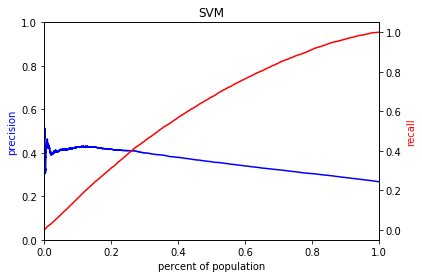

In [422]:
library.plot_precision_recall_n(y_test_best, y_pred_probs_best, "SVM")

In [423]:
model_compare = results_without_baseline[['model_type', 'auc-roc', 'p_at_5', 'r_at_5']]
model_compare[['p_at_5', 'r_at_5']] = model_compare[['p_at_5', 'r_at_5']].apply(pd.to_numeric)
model_compare = model_compare.groupby('model_type').mean()
model_compare.reset_index(inplace=True)

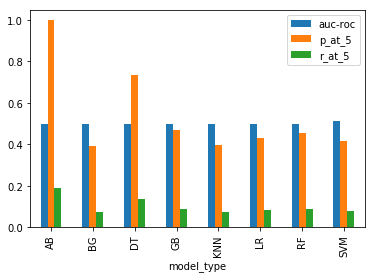

In [424]:
model_compare.plot(x='model_type', y=['auc-roc', 'p_at_5', 'r_at_5'], kind='bar')

In [426]:
model_compare_time = results_without_baseline[['model_type', 'auc-roc', 'p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50', 'test_start']]
model_compare_time[['p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50']] = model_compare_time[['p_at_5', 'r_at_5', 'p_at_10', 'r_at_10', 'p_at_20', 'r_at_20', 'p_at_30', 'r_at_30', 'p_at_50', 'r_at_50']].apply(pd.to_numeric)
model_compare_time = model_compare_time.groupby(['model_type', 'test_start']).mean()
model_compare_time.reset_index(inplace=True)
model_compare_time

model_type test_start   auc-roc    p_at_5    r_at_5   p_at_10   r_at_10  \
0         AB 2013-07-01  0.497006  1.000000  0.187255  1.000000  0.374511   
1         BG 2013-07-01  0.497440  0.394170  0.073810  0.395437  0.148095   
2         DT 2013-07-01  0.498552  0.734764  0.137589  0.664607  0.248902   
3         GB 2013-07-01  0.498240  0.468314  0.087694  0.447323  0.167527   
4        KNN 2013-07-01  0.499795  0.398289  0.074582  0.419518  0.157114   
5         LR 2013-07-01  0.500063  0.432589  0.081005  0.419677  0.157173   
6         RF 2013-07-01  0.499247  0.456247  0.085435  0.428232  0.160377   
7        SVM 2013-07-01  0.510648  0.415082  0.077726  0.426172  0.159606   

    p_at_20   r_at_20   p_at_30   r_at_30   p_at_50   r_at_50  
0  1.000000  0.749021  0.745353  0.837427  0.447183  0.837427  
1  0.379911  0.284562  0.361534  0.406194  0.330651  0.619200  
2  0.564949  0.423159  0.475954  0.534749  0.418528  0.783765  
3  0.408706  0.306129  0.384823  0.432360  0.356742  0.668061  
4  0.360345  0.269906  0.354246  0.398006  0.335974  0.629168  
5  0.400190  0.299751  0.380241  0.427213  0.343728  0.643690  
6  0.388222  0.290787  0.389417  0.437522  0.361334  0.676659  
7  0.416984  0.312329  0.399451  0.448796  0.358913  0.672125